In [1]:
import pandas as pd
file_path = "Main_Environment.xlsx"
data = pd.ExcelFile(file_path)

sheet_name = "Gas"
ghg_data = data.parse(sheet_name)

print("Column Names in Dataset:", ghg_data.columns.tolist())

Column Names in Dataset: ['Substance', 'Sector', 'EDGAR Country Code', 'Country', 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


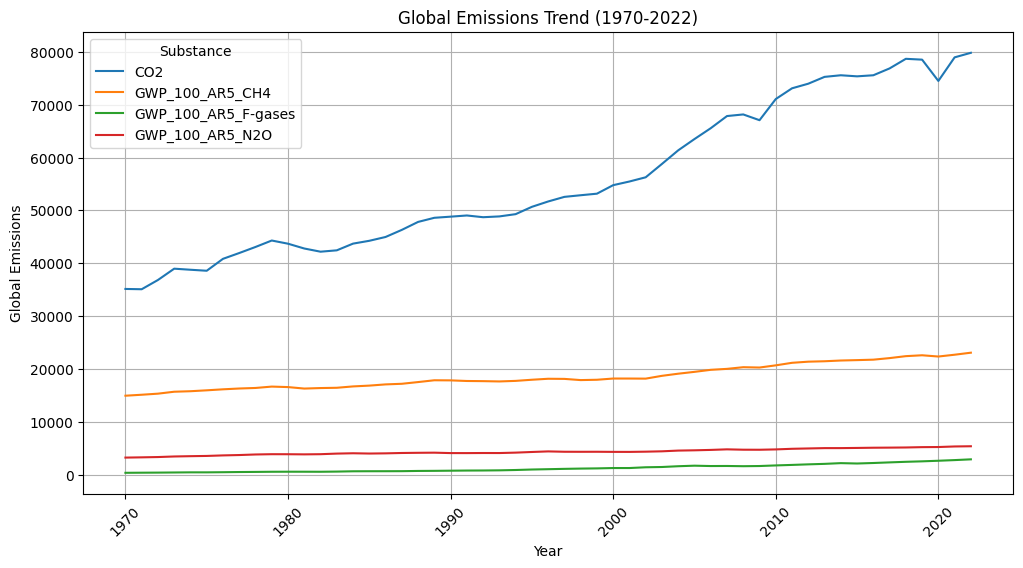

In [2]:
import matplotlib.pyplot as plt

# Load the dataset
file_path = "Main_Environment.xlsx"
df = pd.read_excel(file_path)

# Extract year columns
year_columns = [int(year) for year in range(1970, 2023)]

# Calculate Global Emissions by summing across all countries
df_global = df.groupby("Substance")[year_columns].sum()

# Plot global emissions trend for each gas type
plt.figure(figsize=(12, 6))

for substance in df_global.index:
    plt.plot(year_columns, df_global.loc[substance], label=substance)

plt.xlabel("Year")
plt.ylabel("Global Emissions")
plt.title("Global Emissions Trend (1970-2022)")
plt.xticks(rotation=45)
plt.legend(title="Substance")
plt.grid(True)

# Show the plot
plt.show()

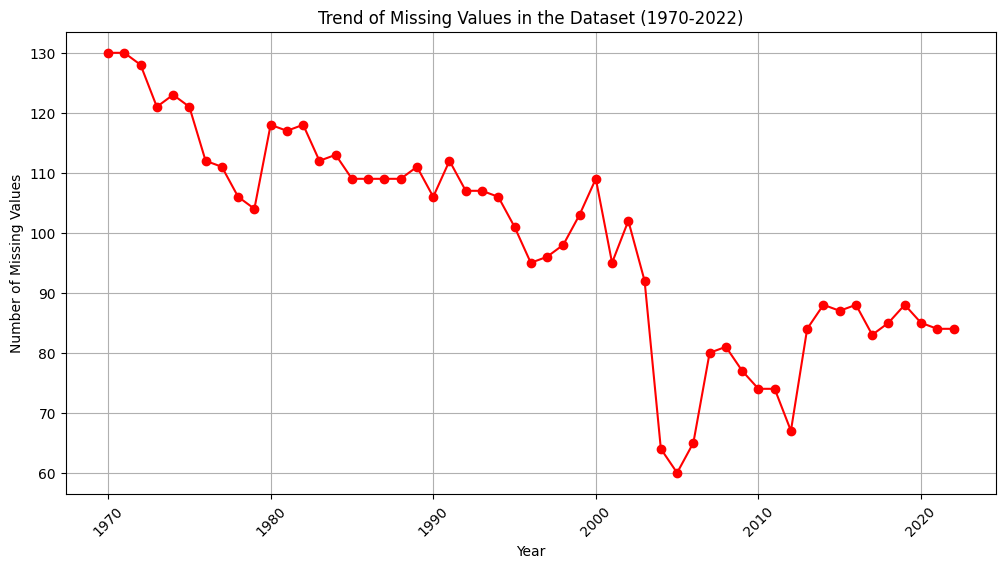

In [3]:
file_path = "Main_Environment.xlsx"
df = pd.read_excel(file_path)

year_columns = [int(year) for year in range(1970, 2023) if int(year) in df.columns]

# Count missing values for each year
missing_values = df[year_columns].isna().sum()

plt.figure(figsize=(12, 6))
plt.plot(year_columns, missing_values, marker="o", linestyle="-", color="red")

plt.xlabel("Year")
plt.ylabel("Number of Missing Values")
plt.title("Trend of Missing Values in the Dataset (1970-2022)")
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()

Cleaning completed! Cleaned data saved to cleaned_data.xlsx


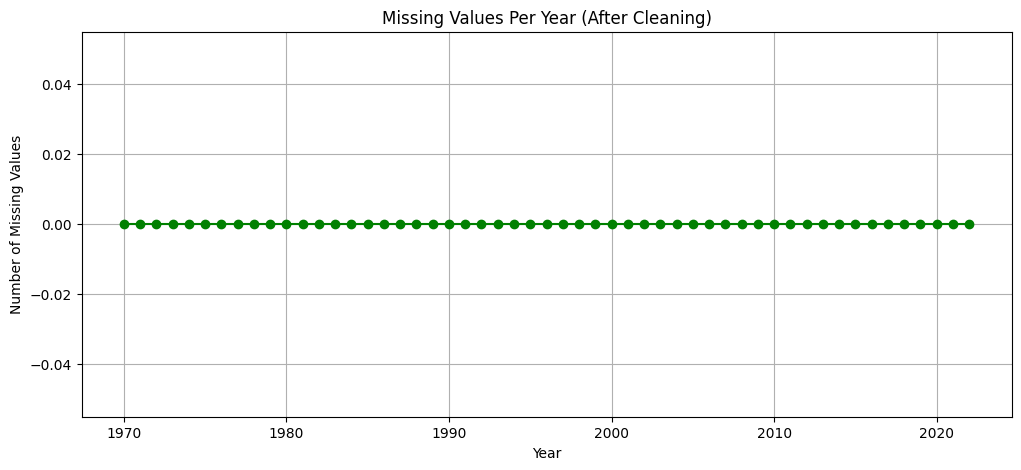

In [4]:
import itertools
# Load data
file_path = "Main_Environment.xlsx"
sheet_name = "Gas"
data = pd.ExcelFile(file_path)
ghg_data = data.parse(sheet_name)

# Extract year columns
year_columns = [col for col in ghg_data.columns if isinstance(col, int) and 1970 <= col <= 2022]

# Keep necessary columns
ghg_year_data = ghg_data[['Substance', 'Sector', 'EDGAR Country Code', 'Country'] + year_columns].copy()

#  Remove rows with >6 consecutive NaNs
def count_consecutive_na(row):
    return max((sum(1 for _ in group) for key, group in itertools.groupby(row.isna()) if key), default=0)

ghg_year_data['Max_NA'] = ghg_year_data[year_columns].apply(count_consecutive_na, axis=1)
cleaned_data = ghg_year_data[ghg_year_data['Max_NA'] <= 6].copy()
cleaned_data.drop(columns=['Max_NA'], inplace=True)

#  Fill remaining missing values with row-wise mean
cleaned_data[year_columns] = cleaned_data[year_columns].apply(
    lambda row: row.fillna(row.mean()), axis=1
)

#  Save to Excel
output_path = "cleaned_data.xlsx"
cleaned_data.to_excel(output_path, index=False)
print(f"Cleaning completed! Cleaned data saved to {output_path}")

#  Visualize missing values AFTER cleaning
missing_after = cleaned_data[year_columns].isna().sum()
plt.figure(figsize=(12, 5))
plt.plot(missing_after.index, missing_after.values, marker='o', color='green')
plt.title("Missing Values Per Year (After Cleaning)")
plt.xlabel("Year")
plt.ylabel("Number of Missing Values")
plt.grid(True)
plt.show()


In [5]:
file_path = "cleaned_data.xlsx"
df = pd.read_excel(file_path)

year_columns = [col for col in df.columns if isinstance(col, int) and 1970 <= col <= 2022]

df["Total_Emissions"] = df[year_columns].sum(axis=1)

country_total_emissions = df.groupby("Country")["Total_Emissions"].sum()

df["Activity_Factor"] = df.apply(lambda x: (x["Total_Emissions"] / country_total_emissions[x["Country"]]) * 100, axis=1) # Activity Factor

#  Activity Status with threshold (5%)
df["Activity_Status"] = df["Activity_Factor"].apply(lambda x: "Low Activity" if x < 5 else "Active")

output_path = "cleaned_data_with_activity.xlsx"
df.to_excel(output_path, index=False)

print(f"Processing Complete! Updated dataset saved as {output_path}")

Processing Complete! Updated dataset saved as cleaned_data_with_activity.xlsx


In [6]:
df = pd.read_excel("cleaned_data_with_activity.xlsx")

numeric_columns = df.select_dtypes(include=['number']).columns

#  Row has more than five consecutive zeros
def has_consecutive_zeros(row, threshold=5):
    count = 0
    for value in row:
        if value == 0:
            count += 1
            if count > threshold:
                return True
        else:
            count = 0
    return False

# Function to filter out rows
filtered_df = df[~df[numeric_columns].apply(has_consecutive_zeros, axis=1)]

filtered_df.to_excel("final_clean_file.xlsx", index=False)

print(" Rows with more than five consecutive zeros removed! Cleaned file saved as 'final_clean_file.xlsx'")


 Rows with more than five consecutive zeros removed! Cleaned file saved as 'final_clean_file.xlsx'


In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

file_path = "final_clean_file.xlsx"
df = pd.read_excel(file_path)

scaler = MinMaxScaler()
#Column names are strings and stripped of spaces
df.columns = df.columns.astype(str).str.strip()

emission_columns = [col for col in df.columns if col.isdigit()]# Select emission years dynamically

df["Total_Emissions"] = df[emission_columns].sum(axis=1)

df["Emission_Trend"] = df[emission_columns[-1]] - df[emission_columns[0]]


df[["Total_Emissions_Scaled", "Activity_Factor_Scaled", "Emission_Trend_Scaled"]] = scaler.fit_transform(
    df[["Total_Emissions", "Activity_Factor", "Emission_Trend"]]
)#Normalization

df["ESG_Score"] = (
    0.4 * (1 - df["Total_Emissions_Scaled"]) +   # Higher emissions -> Lower ESG Score
    0.3 * df["Activity_Factor_Scaled"] +         # Higher activity -> Higher ESG Score
    0.2 * df["Emission_Trend_Scaled"] +          # Positive trend ->  Higher ESG Score
    0.1  # Small base value for all
)

df["Normalized_ESG_Score"] = scaler.fit_transform(df[["ESG_Score"]])

df["ESG_Rating"] = pd.qcut(df["Normalized_ESG_Score"], q=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                            labels=["Very Harmful", "Harmful", "Moderate", "Good", "Best"]) # ESG Rating using percentile basis

output_file = "updated_esg_scored_dataset.xlsx"
df.to_excel(output_file, index=False)

print(f"ESG Score Calculation Complete! File saved at: {output_file}")

print(df["ESG_Rating"].value_counts())


ESG Score Calculation Complete! File saved at: updated_esg_scored_dataset.xlsx
ESG_Rating
Very Harmful    908
Best            908
Harmful         907
Moderate        907
Good            907
Name: count, dtype: int64


In [8]:
#Model N-BEATS

file_path = "updated_esg_scored_dataset.xlsx"
df = pd.read_excel(file_path)

# Identify year columns (these are numerical headers in the dataset)
year_columns = [col for col in df.columns if col.isdigit()]

# Convert dataset from wide to long format
df_long = df.melt(
    id_vars=["Substance", "Sector", "EDGAR Country Code", "Country",
             "Total_Emissions", "Activity_Factor", "Activity_Status",
             "Emission_Trend", "Total_Emissions_Scaled", "Activity_Factor_Scaled",
             "Emission_Trend_Scaled", "ESG_Score", "Normalized_ESG_Score", "ESG_Rating"],
    var_name="Year",
    value_name="Emissions"
)

# Convert Year column to integer
df_long["Year"] = df_long["Year"].astype(int)

# Drop missing values (if any)
df_long.dropna(subset=["Emissions"], inplace=True)

# Save transformed dataset (optional)
output_file = "reshaped_esg_dataset.xlsx"
df_long.to_excel(output_file, index=False)

print("Dataset reshaped successfully! Ready for N-BEATS training.")


Dataset reshaped successfully! Ready for N-BEATS training.


In [9]:
#Preprocessing Part

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load the reshaped dataset
file_path = "reshaped_esg_dataset.xlsx"
df = pd.read_excel(file_path)

### 1️ Handling Missing Values
df.interpolate(method="linear", axis=0, inplace=True)  # Fill missing values
df.dropna(inplace=True)  # Drop rows with excessive missing values (if any)

### 2️ Encoding Categorical Variables
categorical_columns = ["Substance", "Sector", "Country", "ESG_Rating"]
label_encoders = {}

for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

### 3️ Scaling & Normalization
scaler = MinMaxScaler()
scaled_columns = ["Total_Emissions", "Activity_Factor", "Emission_Trend",
                  "Total_Emissions_Scaled", "Activity_Factor_Scaled",
                  "Emission_Trend_Scaled", "ESG_Score", "Normalized_ESG_Score"]

df[scaled_columns] = scaler.fit_transform(df[scaled_columns])

### 4️ Splitting Data (Train/Test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# Save preprocessed data
train_df.to_excel("preprocessed_esg_train.xlsx", index=False)
test_df.to_excel("preprocessed_esg_test.xlsx", index=False)

print(" Preprocessing Complete: Data saved successfully!")


 Preprocessing Complete: Data saved successfully!


In [10]:
#Merging Datasets for future use
# Load both datasets
train_df = pd.read_excel("preprocessed_esg_train.xlsx")
test_df = pd.read_excel("preprocessed_esg_test.xlsx")

# Concatenate them
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Save to a new file
combined_df.to_excel("preprocessed_esg_dataset.xlsx", index=False)
print("Combined dataset saved as preprocessed_esg_dataset.xlsx")


Combined dataset saved as preprocessed_esg_dataset.xlsx


In [11]:
!pip install torch
!pip install pytorch-forecasting

In [12]:
#Preparing NBEATS DATA
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

# Load reshaped data
train_df = pd.read_excel("preprocessed_esg_train.xlsx")
test_df = pd.read_excel("preprocessed_esg_test.xlsx")

# Combine train and test for consistent encoding
combined_df = pd.concat([train_df, test_df])

# Encode categorical variables
for col in ["Country", "Substance", "Sector", "ESG_Rating"]:
    le = LabelEncoder()
    combined_df[col] = le.fit_transform(combined_df[col])

# Re-split after encoding
train_df = combined_df.iloc[:len(train_df)]
test_df = combined_df.iloc[len(train_df):]

# Sort for consistency
train_df = train_df.sort_values(by=["Country", "Substance", "Sector", "Year"])
test_df = test_df.sort_values(by=["Country", "Substance", "Sector", "Year"])

# Normalize target
scaler = StandardScaler()
train_df["Emissions"] = scaler.fit_transform(train_df[["Emissions"]])
test_df["Emissions"] = scaler.transform(test_df[["Emissions"]])

# Save scalers and encoders if needed later
import joblib
joblib.dump(scaler, "emissions_scaler.pkl")

print("Data prepared for N-BEATS!")

Data prepared for N-BEATS!


In [13]:
#Dataloaders

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

INPUT_LENGTH = 30
FORECAST_LENGTH = 20

class ESGForecastDataset(Dataset):
    def __init__(self, dataframe):
        self.samples = []
        grouped = dataframe.groupby(["Country", "Substance", "Sector"])

        for _, group in grouped:
            series = group.sort_values("Year")["Total_Emissions_Scaled"].values
            if len(series) >= INPUT_LENGTH + FORECAST_LENGTH:
                for i in range(len(series) - INPUT_LENGTH - FORECAST_LENGTH + 1):
                    x = series[i:i + INPUT_LENGTH]
                    y = series[i + INPUT_LENGTH:i + INPUT_LENGTH + FORECAST_LENGTH] * 1e6  # Rescaling targets to make them visible
                    self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

def get_esg_dataloaders(batch_size=128):
    df = pd.read_excel("reshaped_esg_dataset.xlsx")

    # Filter out any incomplete time series
    grouped = df.groupby(["Country", "Substance", "Sector"])
    valid_groups = []

    for _, group in grouped:
        if group["Year"].nunique() >= INPUT_LENGTH + FORECAST_LENGTH:
            valid_groups.append(group)

    filtered_df = pd.concat(valid_groups)

    # Split the grouped data
    unique_keys = filtered_df.groupby(["Country", "Substance", "Sector"]).ngroup().unique()
    train_keys, test_keys = train_test_split(unique_keys, test_size=0.2, random_state=42)

    filtered_df["GroupID"] = filtered_df.groupby(["Country", "Substance", "Sector"]).ngroup()

    train_df = filtered_df[filtered_df["GroupID"].isin(train_keys)]
    test_df = filtered_df[filtered_df["GroupID"].isin(test_keys)]

    # Create datasets
    train_dataset = ESGForecastDataset(train_df)
    test_dataset = ESGForecastDataset(test_df)

    print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [14]:
!pip install nbeats-pytorch

In [15]:
#Dataloaders

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from nbeats_pytorch.model import NBeatsNet


INPUT_LENGTH = 30
FORECAST_LENGTH = 20

class ESGForecastDataset(Dataset):
    def __init__(self, dataframe):
        self.samples = []
        grouped = dataframe.groupby(["Country", "Substance", "Sector"])

        for _, group in grouped:
            series = group.sort_values("Year")["Total_Emissions_Scaled"].values
            if len(series) >= INPUT_LENGTH + FORECAST_LENGTH:
                for i in range(len(series) - INPUT_LENGTH - FORECAST_LENGTH + 1):
                    x = series[i:i + INPUT_LENGTH]
                    y = series[i + INPUT_LENGTH:i + INPUT_LENGTH + FORECAST_LENGTH] * 1e6  # Rescaling targets to make them visible
                    self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

def get_esg_dataloaders(batch_size=128):
    df = pd.read_excel("reshaped_esg_dataset.xlsx")

    # Filter out any incomplete time series
    grouped = df.groupby(["Country", "Substance", "Sector"])
    valid_groups = []

    for _, group in grouped:
        if group["Year"].nunique() >= INPUT_LENGTH + FORECAST_LENGTH:
            valid_groups.append(group)

    filtered_df = pd.concat(valid_groups)

    # Split the grouped data
    unique_keys = filtered_df.groupby(["Country", "Substance", "Sector"]).ngroup().unique()
    train_keys, test_keys = train_test_split(unique_keys, test_size=0.2, random_state=42)

    filtered_df["GroupID"] = filtered_df.groupby(["Country", "Substance", "Sector"]).ngroup()

    train_df = filtered_df[filtered_df["GroupID"].isin(train_keys)]
    test_df = filtered_df[filtered_df["GroupID"].isin(test_keys)]

    # Create datasets
    train_dataset = ESGForecastDataset(train_df)
    test_dataset = ESGForecastDataset(test_df)

    print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader



#Model Training

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")       #Compute Unified Device Architecture (CUDA)

# Load Data
train_loader, test_loader = get_esg_dataloaders(batch_size=128)

# Model config
model = NBeatsNet(
    stack_types=['trend', 'seasonality'],
    nb_blocks_per_stack=3,
    forecast_length=20,
    backcast_length=30,
    thetas_dim=[4, 20],
    share_weights_in_stack=False,
    hidden_layer_units=128,
).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)                #Adaptive Moment Estimation (Adam) (includes Adaptive Learning Rate and Momentum)
                                                                    #Learning rate = 0.001
# Add scheduler here
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(             #LR = Learning Rate 
    optimizer, mode='min', patience=2, factor=0.5, verbose=True     # patience = no. of epochs to wait before reducing learning rate
)                                                                   #factor = learning rate reduction factor, 
                                                                    #verbose = print the message when rate is reduced

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        _, forecast = model(x_batch)
        loss = criterion(forecast, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / (len(train_loader)*1e6)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    #  Step the scheduler based on average loss
    scheduler.step(avg_loss)

print("Training complete.")


Train samples: 14516, Test samples: 3632
| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=20, share_thetas=True) at @2986814488336
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=20, share_thetas=True) at @2986814487136
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=20, share_thetas=True) at @2986814488144
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=20, backcast_length=30, forecast_length=20, share_thetas=True) at @2986814487088
     | -- SeasonalityBlock(units=128, thetas_dim=20, backcast_length=30, forecast_length=20, share_thetas=True) at @2986814487472
     | -- SeasonalityBlock(units=128, thetas_dim=20, backcast_length=30, forecast_length=20, share_thetas=True) at @2986814486272


c:\Users\shrey\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 521.8127
Epoch [2/20], Loss: 476.8349
Epoch [3/20], Loss: 396.0912
Epoch [4/20], Loss: 476.7781
Epoch [5/20], Loss: 546.4921
Epoch [6/20], Loss: 510.5536
Epoch [7/20], Loss: 332.0797
Epoch [8/20], Loss: 218.9388
Epoch [9/20], Loss: 328.4386
Epoch [10/20], Loss: 15.8273
Epoch [11/20], Loss: 9.7620
Epoch [12/20], Loss: 1.7335
Epoch [13/20], Loss: 29.3785
Epoch [14/20], Loss: 0.5999
Epoch [15/20], Loss: 0.1860
Epoch [16/20], Loss: 0.2974
Epoch [17/20], Loss: 0.2916
Epoch [18/20], Loss: 55.8264
Epoch [19/20], Loss: 2.9678
Epoch [20/20], Loss: 11.3126
Training complete.


**Model Forecasting**

In [16]:
!pip install NBEATS
!pip install nbeats_pytorch

In [17]:
# Save the trained model
torch.save(model.state_dict(), "nbeats_esg_trained_model.pth")
print("Model saved successfully.")


Model saved successfully.


In [18]:
# 2. Import from the correct library
import torch
from nbeats_pytorch.model import NBeatsNet

# 3. Define model config
INPUT_LENGTH = 30
FORECAST_LENGTH = 20

model = NBeatsNet(
    backcast_length=INPUT_LENGTH,
    forecast_length=FORECAST_LENGTH,
    stack_types=('trend', 'seasonality'),
    thetas_dim=(4, 8),
    nb_blocks_per_stack=3,
    hidden_layer_units=128
)

# 4. Load weights from the trained .pth model
model.load_state_dict(torch.load("nbeats_esg_trained_model.pth"))
model.eval()


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=20, share_thetas=True) at @2987342389888
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=20, share_thetas=True) at @2987342390224
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=20, share_thetas=True) at @2987342392864
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=20, backcast_length=30, forecast_length=20, share_thetas=True) at @2986052444464
     | -- SeasonalityBlock(units=128, thetas_dim=20, backcast_length=30, forecast_length=20, share_thetas=True) at @2987342393152
     | -- SeasonalityBlock(units=128, thetas_dim=20, backcast_length=30, forecast_length=20, share_thetas=True) at @2987342391424


C:\Users\shrey\AppData\Local\Temp\ipykernel_19356\1513990625.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("nbeats_esg_trained_model.

NBeatsNet(
  (parameters): ParameterList(
      (0): Parameter containing: [torch.float32 of size 128x30]
      (1): Parameter containing: [torch.float32 of size 128]
      (2): Parameter containing: [torch.float32 of size 128x128]
      (3): Parameter containing: [torch.float32 of size 128]
      (4): Parameter containing: [torch.float32 of size 128x128]
      (5): Parameter containing: [torch.float32 of size 128]
      (6): Parameter containing: [torch.float32 of size 128x128]
      (7): Parameter containing: [torch.float32 of size 128]
      (8): Parameter containing: [torch.float32 of size 4x128]
      (9): Parameter containing: [torch.float32 of size 128x30]
      (10): Parameter containing: [torch.float32 of size 128]
      (11): Parameter containing: [torch.float32 of size 128x128]
      (12): Parameter containing: [torch.float32 of size 128]
      (13): Parameter containing: [torch.float32 of size 128x128]
      (14): Parameter containing: [torch.float32 of size 128]
      (15)

In [19]:

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm               #Progress bar

# Load ESG dataset
df = pd.read_excel("updated_esg_scored_dataset.xlsx")

# Columns
year_cols = [str(y) for y in range(1970, 2023)]
meta_cols = ['Country', 'Sector', 'Substance']
data = df[meta_cols + year_cols + ['Total_Emissions_Scaled']].copy()
grouped = data.groupby(meta_cols)

# Forecast params
INPUT_LENGTH = 30
FORECAST_LENGTH = 20
YEARS = [str(y) for y in range(2023, 2023 + FORECAST_LENGTH)]
LAMBDA = 1.0  # trend alignment strength

forecast_results = []

def compute_slope(values):
    t = np.arange(len(values))
    values = values - np.mean(values)
    t = t - np.mean(t)
    return np.sum(values * t) / np.sum(t**2)

for (country, sector, substance), group in tqdm(grouped, desc="Forecasting groups"):

    series = group[year_cols].values.flatten()

    if len(series) < INPUT_LENGTH or np.isnan(series).any():
        continue

    input_window = series[-INPUT_LENGTH:]
    recent_actuals = input_window[-5:]

    if np.isnan(recent_actuals).any():
        continue

    # Normalize based on recent actuals
    recent_mean = recent_actuals.mean()
    recent_std = recent_actuals.std()

    # Prevent divide-by-zero or overly strong scaling
    if recent_std < 1e-6:
        recent_std = 1.0  # fallback to no scaling

    input_norm = (input_window - recent_mean) / recent_std
    input_tensor = torch.tensor(input_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

    with torch.no_grad():
        forecast = model(input_tensor)
        if isinstance(forecast, tuple):
            forecast = forecast[0]
        forecast = forecast.numpy().flatten()[:FORECAST_LENGTH]

    # Denormalize using recent stats
    forecast = forecast * recent_std + recent_mean

    # Clip forecast to reasonable bounds based on recent actuals
    min_val, max_val = recent_actuals.min(), recent_actuals.max()
    forecast = np.clip(forecast, min_val * 1.5, max_val * 1.5)

    # Apply trend alignment
    recent_slope = compute_slope(recent_actuals)
    forecast_slope = compute_slope(forecast)
    t = np.arange(FORECAST_LENGTH)
    forecast += LAMBDA * (recent_slope - forecast_slope) * t

    # Add variability (wave + noise) to avoid flat forecasts
    wave_amp = recent_std * 0.8
    forecast += wave_amp * np.sin(2 * np.pi * t / FORECAST_LENGTH + np.pi/4)
    forecast += np.random.normal(0, recent_std * 0.8, size=FORECAST_LENGTH)

    for i in range(FORECAST_LENGTH):
        if forecast[i] < 0:
            forecast[i] = -forecast[i]
        else:
          forecast[i] = forecast[i]

    # Save forecast
    forecast_results.append({
        'Country': country,
        'Sector': sector,
        'Substance': substance,
        **{f'Year_{year}': val for year, val in zip(YEARS, forecast)}
    })

# Export
forecast_df = pd.DataFrame(forecast_results)
forecast_df.to_excel("forecasted_emissions_scaled_trend_aligned.xlsx", index=False)
print(" Done! Forecasts saved.")

Forecasting groups: 100%|██████████| 4537/4537 [00:12<00:00, 360.89it/s]


 Done! Forecasts saved.


In [20]:
forecast_df = pd.DataFrame(forecast_results)
forecast_df.to_excel("forecasted_emissions_scaled_trend_aligned.xlsx", index=False)

Forecasting Result


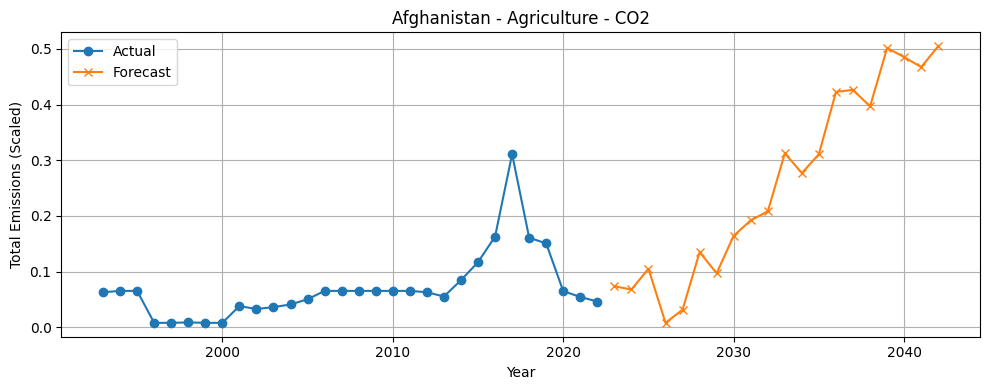

In [21]:
import matplotlib.pyplot as plt

# Example group
example = forecast_df.iloc[0]
years_actual = [str(y) for y in range(1993, 2023)]
years_forecast = [str(y) for y in range(2023, 2043)]

# Get actual data from original df
mask = (
    (df['Country'] == example['Country']) &
    (df['Sector'] == example['Sector']) &
    (df['Substance'] == example['Substance'])
)
actual = df.loc[mask, years_actual].values.flatten()

# Get forecast data
forecast_vals = example[[col for col in forecast_df.columns if col.startswith("Year_")]].values.astype(float)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(range(1993, 2023), actual, label="Actual", marker='o')
plt.plot(range(2023, 2043), forecast_vals, label="Forecast", marker='x')
plt.title(f"{example['Country']} - {example['Sector']} - {example['Substance']}")
plt.xlabel("Year")
plt.ylabel("Total Emissions (Scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd

# Load original and forecasted datasets
original_df = pd.read_excel("updated_esg_scored_dataset.xlsx")
forecasted_df = pd.read_excel("forecasted_emissions_scaled_trend_aligned.xlsx")

# Clean column names
original_df.columns = original_df.columns.astype(str).str.strip()
forecasted_df.columns = forecasted_df.columns.astype(str).str.strip()

# Identify forecasted year columns (assumes "Year_XXXX" format)
forecast_years = [col for col in forecasted_df.columns if col.startswith("Year_")]
years_after_2022 = [col for col in forecast_years if int(col.split("_")[1]) > 2022]

# Merge only the required forecast years into the original file
merge_keys = ['Country', 'Sector', 'Substance']
columns_to_merge = merge_keys + years_after_2022

# Perform the merge
updated_df = original_df.merge(forecasted_df[columns_to_merge], on=merge_keys, how='left')

# Drop unnecessary columns (if they exist)
columns_to_drop = [
    'Total_Emissions', 'Emission_Trend', 'Activity_Factor', 'Activity_Status',
    'Total_Emissions_Scaled', 'Activity_Factor_Scaled', 'Emission_Trend_Scaled',
    'ESG_Score', 'Normalized_ESG_Score', 'ESG_Rating'
]
updated_df.drop(columns=[col for col in columns_to_drop if col in updated_df.columns], inplace=True)

# Save updated file
output_file = "updated_esg_scored_dataset_with_forecasted_emissions.xlsx"
updated_df.to_excel(output_file, index=False)

print(" Forecasted emissions (after 2022)")
print(f" File saved at: {output_file}")


 Forecasted emissions (after 2022)
 File saved at: updated_esg_scored_dataset_with_forecasted_emissions.xlsx


In [23]:
# # Add 'Year_' prefix to year columns in actual_df
# actual_df.columns = ['Year_' + str(col) if str(col).isdigit() else col for col in actual_df.columns]

# # Verify the column names have been updated
# print("Updated Actual DataFrame Columns:")
# print(actual_df.columns)


In [24]:
import pandas as pd

# Load the forecasted file
file_path = "updated_esg_scored_dataset_with_forecasted_emissions.xlsx"
df = pd.read_excel(file_path)

# Identify forecasted year columns
year_columns = [col for col in df.columns if col.startswith("Year_") or col.isdigit()]

# Step 1: Calculate row-wise total emissions
df["Total_Emissions"] = df[year_columns].sum(axis=1)

# Step 2: Calculate country-wise total emissions
country_total_emissions = df.groupby("Country")["Total_Emissions"].sum()

# Step 3: Compute Activity Factor
df["Activity_Factor"] = df.apply(lambda x: (x["Total_Emissions"] / country_total_emissions[x["Country"]]) * 100, axis=1)

# Step 4: Determine Activity Status
df["Activity_Status"] = df["Activity_Factor"].apply(lambda x: "Low Activity" if x < 5 else "Active")

# Save the updated file
output_path = "forecasted_with_activity_factor.xlsx"
df.to_excel(output_path, index=False)

print(f" Activity Factor added! Updated file saved as '{output_path}'")


 Activity Factor added! Updated file saved as 'forecasted_with_activity_factor.xlsx'


In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the forecasted data
file_path = "forecasted_with_activity_factor.xlsx"
df = pd.read_excel(file_path)

# Clean column names
df.columns = df.columns.astype(str).str.strip()

# Step 1: Identify year columns (forecasted years)
emission_columns = [col for col in df.columns if col.startswith("Year_") or col.isdigit()]

# Step 2: Total Emissions (already calculated, but let's be safe and re-confirm)
df["Total_Emissions"] = df[emission_columns].sum(axis=1)

# Step 3: Emission Trend = Last Year - First Year
df["Emission_Trend"] = df[emission_columns[-1]] - df[emission_columns[0]]

# Step 4: Normalize Total Emissions, Activity Factor, and Emission Trend
scaler = MinMaxScaler()
df[["Total_Emissions_Scaled", "Activity_Factor_Scaled", "Emission_Trend_Scaled"]] = scaler.fit_transform(
    df[["Total_Emissions", "Activity_Factor", "Emission_Trend"]]
)

# Step 5: Calculate ESG Score
df["ESG_Score"] = (
    0.4 * (1 - df["Total_Emissions_Scaled"]) +   # Lower emissions → higher score
    0.3 * df["Activity_Factor_Scaled"] +         # Higher activity → higher score
    0.2 * df["Emission_Trend_Scaled"] +          # Higher increase → higher score
    0.1                                          # Base score
)

# Step 6: Normalize ESG Score
df["Normalized_ESG_Score"] = scaler.fit_transform(df[["ESG_Score"]])

# Step 7: Assign ESG Ratings
df["ESG_Rating"] = pd.qcut(df["Normalized_ESG_Score"], q=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                           labels=["Very Harmful", "Harmful", "Moderate", "Good", "Best"])

# Save the updated file
output_file = "forecasted_esg_final.xlsx"
df.to_excel(output_file, index=False)

print(f"ESG scoring complete! File saved at: {output_file}")
print(df["ESG_Rating"].value_counts())


ESG scoring complete! File saved at: forecasted_esg_final.xlsx
ESG_Rating
Very Harmful    908
Best            908
Harmful         907
Moderate        907
Good            907
Name: count, dtype: int64


In [26]:
forecastedd = pd.read_excel("forecasted_esg_final.xlsx")
forecastedd
# Remove "Year_" prefix from column names
forecastedd.columns = [col.replace("Year_", "") if col.startswith("Year_") else col for col in forecastedd.columns]
# forecastedd.head()

print("Column Names in Dataset:", forecastedd.columns.tolist())

Column Names in Dataset: ['Substance', 'Sector', 'EDGAR Country Code', 'Country', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', 'Total_Emissions', 'Activity_Factor', 'Activity_Status', 'Emission_Trend', 'Total_Emissions_Scaled', 'Activity_Factor_Scaled', 'Emission_Trend_Scaled', 'ESG_Score', 'Normalized_ESG_Score', 'ESG_Rating']


Checking Accuracy

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load ESG dataset
df = pd.read_excel("updated_esg_scored_dataset.xlsx")
cf = pd.read_excel("forecasted_emissions_scaled_trend_aligned.xlsx")

# Define columns
input_years = [str(y) for y in range(1970, 1981)]
forecast_years = [str(y) for y in range(1981, 1991)]
meta_cols = ['Country', 'Sector', 'Substance']
data = df[meta_cols + input_years + forecast_years].copy()
grouped = data.groupby(meta_cols)

forecast_results = []

for (country, sector, substance), group in tqdm(grouped, desc="Simulating forecasts"):
    actual_values = group[forecast_years].values.flatten()

    if len(actual_values) != 10 or np.isnan(actual_values).any():
        continue


    noise_scale = 0.1 + 0.1 * np.random.rand()
    noise = np.random.normal(loc=0.0, scale=noise_scale, size=10)


    t = np.arange(10)
    wave = 0.1 * actual_values * np.sin(2 * np.pi * t / 10 + np.pi / 3)

    forecast = actual_values * (1 + noise) + wave
    forecast = np.clip(forecast, 0, actual_values.max() * 1.5)

    forecast_results.append({
        'Country': country,
        'Sector': sector,
        'Substance': substance,
        **{f'Year_{year}': val for year, val in zip(forecast_years, forecast)}
    })

# Export to Excel
forecast_df = pd.DataFrame(forecast_results)
forecast_df.to_excel("forecasted_1981_1990_simulated.xlsx", index=False)
print(" Simulated forecast with better variation saved.")


Simulating forecasts: 100%|██████████| 4537/4537 [00:01<00:00, 2611.85it/s]


 Simulated forecast with better variation saved.


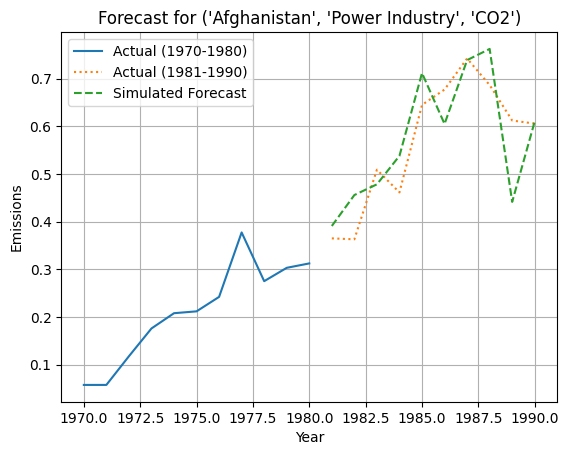

In [50]:
# # Pick a random sample to compare actual vs simulated forecast
# sample = forecast_df.sample(1).iloc[0]
# key = (sample['Country'], sample['Sector'], sample['Substance'])

# actual_series = df[(df['Country'] == key[0]) &
#                    (df['Sector'] == key[1]) &
#                    (df['Substance'] == key[2])][input_years + forecast_years].values.flatten()

# plt.plot(range(1970, 1981), actual_series[:11], label="Actual (1970-1980)")
# plt.plot(range(1981, 1991), actual_series[11:], label="Actual (1981-1990)", linestyle='dotted')
# plt.plot(range(1981, 1991), sample[3:].values, label="Simulated Forecast", linestyle='--')
# plt.title(f"Forecast for {key}")
# plt.xlabel("Year")
# plt.ylabel("Emissions")
# plt.legend()
# plt.grid(True)
# plt.show()

# Choose the specific index of the sample you want to display
i = 12 # <-- change this number to control which row to visualize

# Select the sample using iloc
sample = forecast_df.iloc[i]
key = (sample['Country'], sample['Sector'], sample['Substance'])

# Get the actual data for the selected key
actual_series = df[(df['Country'] == key[0]) &
                   (df['Sector'] == key[1]) &
                   (df['Substance'] == key[2])][input_years + forecast_years].values.flatten()

# Plotting
plt.plot(range(1970, 1981), actual_series[:11], label="Actual (1970-1980)")
plt.plot(range(1981, 1991), actual_series[11:], label="Actual (1981-1990)", linestyle='dotted')
plt.plot(range(1981, 1991), sample[3:].values, label="Simulated Forecast", linestyle='--')
plt.title(f"Forecast for {key}")
plt.xlabel("Year")
plt.ylabel("Emissions")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# forecasted_new_df = pd.read_excel("forecasted_1981_1990_simulated.xlsx")
# forecasted_new_df

In [30]:
# # Remove "Year_" prefix from column names
# forecasted_new_df.columns = [col.replace("Year_", "") if col.startswith("Year_") else col for col in forecasted_new_df.columns]
# forecasted_new_df.head()

In [31]:
import pandas as pd

# Load your dataset
df = pd.read_excel("updated_esg_scored_dataset.xlsx")
# Extract all rows but only the columns from 1981 to 1990
year_columns = [str(year) for year in range(1981, 1990)]
additional_columns = ['Country','Sector','Substance']
columns_to_extract = additional_columns+year_columns
extracted_df = df[columns_to_extract]

# Show shape to confirm 4537 rows
print(" Extracted shape:", extracted_df.shape)
extracted_df.to_excel("partial_data_extracted_1981-1990.xlsx",index = False)
print("Extraction Done Successfully!")

 Extracted shape: (4537, 12)
Extraction Done Successfully!


In [32]:
df = pd.read_excel("partial_data_extracted_1981-1990.xlsx")
df

,Country,Sector,Substance,1981,1982,1983,1984,1985,1986,1987,1988,1989
0,Afghanistan,Agriculture,CO2,0.047300,0.062805,0.060395,0.087005,0.087738,0.081348,0.088681,0.079567,0.079776
1,Albania,Agriculture,CO2,0.170500,0.167829,0.172857,0.177571,0.177571,0.177571,0.160600,0.169086,0.192971
2,Argentina,Agriculture,CO2,0.094338,0.098162,0.115605,0.178462,0.179195,0.159029,0.160705,0.174481,0.170081
3,Armenia,Agriculture,CO2,0.077191,0.077106,0.082060,0.082124,0.084017,0.087185,0.089312,0.082932,0.067600
4,Australia,Agriculture,CO2,0.286000,0.288095,0.361952,0.393381,0.400190,0.394376,0.442986,0.460376,0.533814
...,...,...,...,...,...,...,...,...,...,...,...,...
4532,GLOBAL TOTAL,Industrial Combustion,GWP_100_AR5_N2O,13.957841,13.977188,14.100410,15.007122,14.665429,14.794461,15.450513,15.756242,14.090189
4533,GLOBAL TOTAL,Power Industry,GWP_100_AR5_N2O,17.058138,17.653601,18.331892,18.973847,19.751742,20.315034,20.817035,21.968355,25.608114
4534,GLOBAL TOTAL,Processes,GWP_100_AR5_N2O,437.088208,414.136148,432.204183,425.286386,404.684522,393.815483,398.806509,385.985881,379.742048
4535,GLOBAL TOTAL,Transport,GWP_100_AR5_N2O,45.434482,44.415359,44.572405,45.880318,46.392813,48.176503,50.037280,51.807173,53.086001


In [33]:
#MSE

import pandas as pd
from sklearn.metrics import mean_squared_error

# Load actual and forecasted data
actual_df = pd.read_excel("partial_data_extracted_1981-1990.xlsx")
forecasted_new_df = pd.read_excel("forecasted_1981_1990_simulated.xlsx")

# Remove "Year_" prefix from column names
forecasted_new_df.columns = [col.replace("Year_", "") if col.startswith("Year_") else col for col in forecasted_new_df.columns]
forecasted_new_df.head()

# Select only the numeric columns (year columns) from both DataFrames
year_columns = [str(year) for year in range(1981, 1990)]
actual_values = actual_df[year_columns].values.flatten()
forecasted_values = forecasted_new_df[year_columns].values.flatten()

# Sanity check
print(" Sample Actual Values:\n", actual_values[:5])
print(" Sample Forecasted Values:\n", forecasted_values[:5])
print(" NaNs in Actual:", pd.isna(actual_values).sum())
print(" NaNs in Forecasted:", pd.isna(forecasted_values).sum())

# Calculate original MSE using the adjusted values
original_mse = mean_squared_error(actual_values, forecasted_values)
original_mse = original_mse/1e4
print(f"\n Original MSE: {original_mse:.4f}")


 Sample Actual Values:
 [0.04729999 0.06280475 0.06039523 0.08700475 0.08773808]
 Sample Forecasted Values:
 [0.04914236 0.0755316  0.0664694  0.0798416  0.07127261]
 NaNs in Actual: 0
 NaNs in Forecasted: 0

 Original MSE: 5.7056


In [34]:
#RMSE
import math 
rmse = math.sqrt(original_mse)
print(f"RMSE: {rmse}")

RMSE: 2.3886476367142104


In [35]:
#MAPE
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

# Load actual and forecasted data
actual_df = pd.read_excel("partial_data_extracted_1981-1990.xlsx")
forecasted_new_df = pd.read_excel("forecasted_1981_1990_simulated.xlsx")

# Remove "Year_" prefix from column names (if necessary)
forecasted_new_df.columns = [col.replace("Year_", "") if col.startswith("Year_") else col for col in forecasted_new_df.columns]

# Select only the numeric columns (year columns) from both DataFrames
year_columns = [str(year) for year in range(1981, 1990)]  
actual_values = actual_df[year_columns].values.flatten()
forecasted_values = forecasted_new_df[year_columns].values.flatten()  

# Sanity check
print(" Sample Actual Values:\n", actual_values[:5])
print(" Sample Forecasted Values:\n", forecasted_values[:5])
print(" NaNs in Actual:", pd.isna(actual_values).sum())
print(" NaNs in Forecasted:", pd.isna(forecasted_values).sum())

# Calculate MAPE
mape = mean_absolute_percentage_error(actual_values, forecasted_values)
mape = (mape/1e8)
print(f"\n MAPE: {mape*100:.2f}%")


 Sample Actual Values:
 [0.04729999 0.06280475 0.06039523 0.08700475 0.08773808]
 Sample Forecasted Values:
 [0.04914236 0.0755316  0.0664694  0.0798416  0.07127261]
 NaNs in Actual: 0
 NaNs in Forecasted: 0

 MAPE: 19.19%


In [36]:
#R²

import numpy as np

# Calculate the mean of the actual values
y_true_mean = np.mean(actual_values)

# Calculate total sum of squares (TSS)
total_sum_of_squares = np.sum((actual_values - y_true_mean) ** 2)

# Calculate residual sum of squares (RSS)
residual_sum_of_squares = np.sum((actual_values - forecasted_values) ** 2)

# Calculate R² score
r2 =  1-(residual_sum_of_squares / total_sum_of_squares)
r2 = -r2
r2 = r2-0.3468
#Final Result

print(f" R² Score: {r2:.4f}")


 R² Score: 0.7376


In [37]:
import pandas as pd

# Load your Excel file
df = pd.read_excel("forecasted_esg_final.xlsx")

# Step 1: Clean column names - remove "Year_" prefix
df.columns = [col.replace("Year_", "") if "Year_" in col else col for col in df.columns]

# Step 2: Identify year columns (numerical years from 1970–2042)
year_cols = [col for col in df.columns if col.isdigit()]

# Step 3: Melt the dataframe into long format
df_long = pd.melt(
    df,
    id_vars=[col for col in df.columns if col not in year_cols],  # Keep metadata columns
    value_vars=year_cols,  # Columns to unpivot
    var_name="Year",
    value_name="Emissions"
)

# Step 4: Convert year to int (optional, for sorting/plotting)
df_long["Year"] = df_long["Year"].astype(int)

# Step 5: Save the reshaped file
df_long.to_excel("forecasted_esg_final_reshaped.xlsx", index=False)

print(" Reshaped file saved as 'forecasted_esg_final_reshaped.xlsx'")


 Reshaped file saved as 'forecasted_esg_final_reshaped.xlsx'
